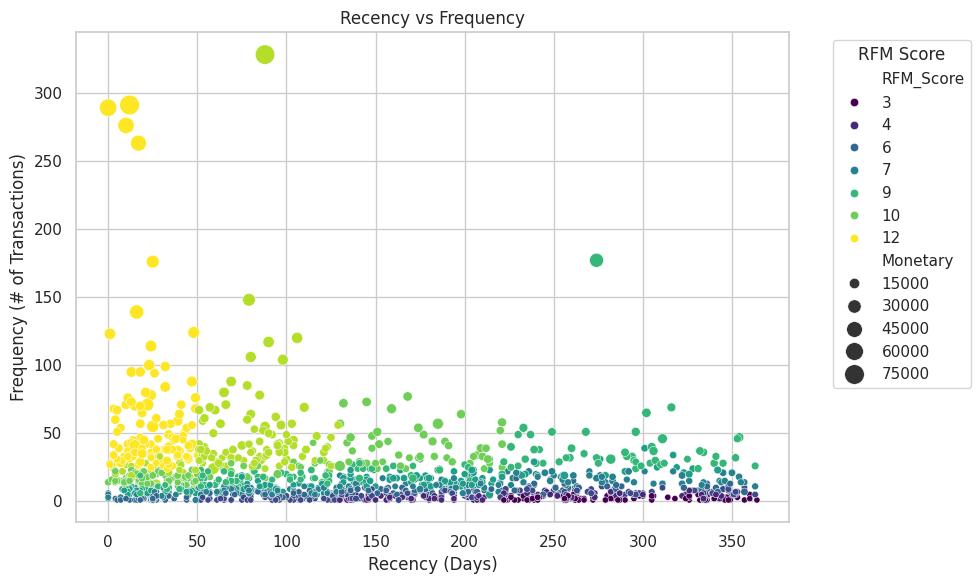

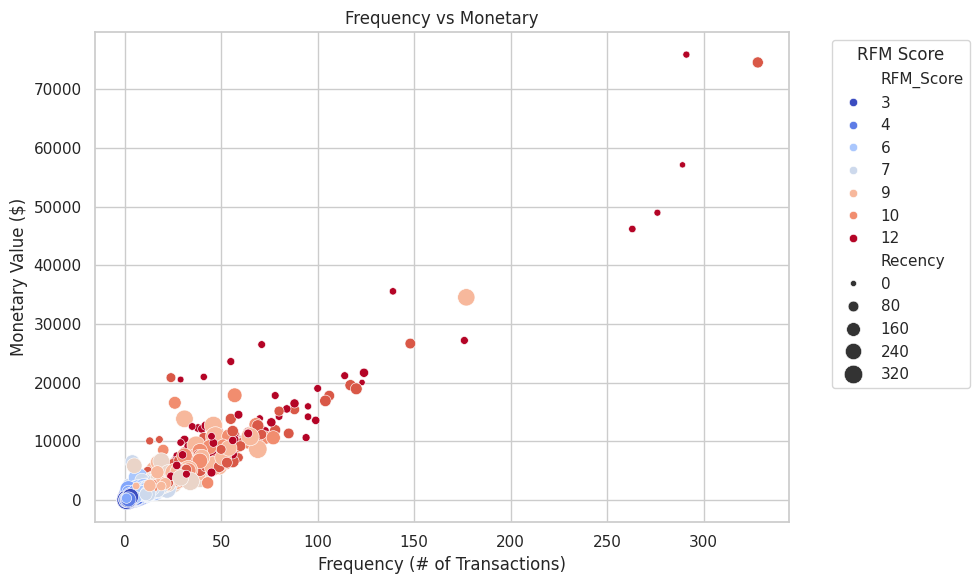

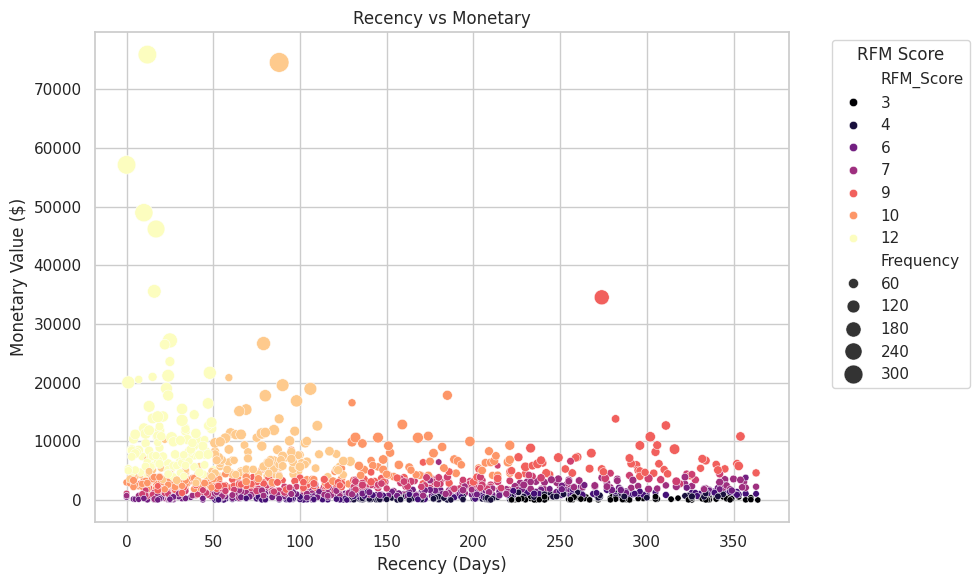

      CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0          12346      107          1     30.99       3       1       1   
1          12347      282         31  13834.90       1       4       4   
2          12348       73          8   1442.12       3       2       2   
3          12350       17         11   1360.07       4       2       2   
4          12356      107         13   1442.47       3       3       2   
...          ...      ...        ...       ...     ...     ...     ...   
1463       18259      241          3    544.34       1       1       1   
1464       18260       53         19   2363.05       3       3       3   
1465       18269      194          2    101.56       2       1       1   
1466       18277       69          1    298.00       3       1       1   
1467       18283       82         53   6362.77       3       4       4   

     RFM_Segment  RFM_Score           CLV  
0            311          5     28.172727  
1            144       

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/Online_Sales_CLV.xlsx'  # Updated file path
df = pd.read_excel(file_path)  # Changed to read_excel

# Check if 'Transaction_Date' column exists
if 'Transaction_Date' not in df.columns:
    raise KeyError("The column 'Transaction_Date' is missing in the dataset.")

# Convert Transaction_Date to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')

# Check for rows with parsing errors
if df['Transaction_Date'].isnull().any():
    print("Warning: Some dates could not be parsed and were set to NaT. Please verify the data.")
    print(df[df['Transaction_Date'].isnull()])  # Display problematic rows

# Drop rows with invalid dates (optional)
df = df.dropna(subset=['Transaction_Date'])

# Define the current date as a reference for recency calculation
current_date = df['Transaction_Date'].max()

# Calculate total revenue for each transaction
df['Revenue'] = df['Quantity'] * df['Avg_Price']

# --- RFM Analysis ---

# Group data by CustomerID to calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (current_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary
}).reset_index()

# Rename columns for RFM
rfm.rename(columns={
    'Transaction_Date': 'Recency',
    'Transaction_ID': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# Add RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # 4: Most recent, 1: Least recent
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # 4: Most frequent
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])  # 4: Highest monetary value

# Combine RFM scores into a single RFM_Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# --- CLV Calculation ---

# Define the discount rate (r) and time horizon (N)
discount_rate = 0.1  # Example: 10% annual discount rate
time_horizon = 12  # Example: Predict CLV for 12 months

# Extract month from Transaction_Date for monthly aggregation
df['Month'] = df['Transaction_Date'].dt.to_period('M')

# Calculate the monthly revenue for each customer
monthly_revenue = df.groupby(['CustomerID', 'Month']).agg({'Revenue': 'sum'}).reset_index()

# Prepare a dataframe to calculate CLV
clv_data = pd.DataFrame({'CustomerID': monthly_revenue['CustomerID'].unique()})

# Function to calculate CLV for each customer
def calculate_clv(customer_id):
    customer_revenue = monthly_revenue[monthly_revenue['CustomerID'] == customer_id]
    total_clv = 0
    for t in range(1, time_horizon + 1):
        # Expected revenue in month t
        if t <= len(customer_revenue):
            expected_revenue = customer_revenue.iloc[t - 1]['Revenue']
        else:
            expected_revenue = 0  # No revenue data for future months
        # Discounted revenue
        total_clv += expected_revenue / ((1 + discount_rate) ** t)
    return total_clv

# Calculate CLV for each customer
clv_data['CLV'] = clv_data['CustomerID'].apply(calculate_clv)

# Merge CLV data with the RFM analysis
rfm_clv = rfm.merge(clv_data, on='CustomerID')

# --- Visualization ---

# Set plot style
sns.set(style="whitegrid")

# Plot Recency vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', data=rfm_clv, hue='RFM_Score', palette='viridis', size='Monetary', sizes=(20, 200))
plt.title('Recency vs Frequency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (# of Transactions)')
plt.legend(title='RFM Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot Frequency vs Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm_clv, hue='RFM_Score', palette='coolwarm', size='Recency', sizes=(20, 200))
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency (# of Transactions)')
plt.ylabel('Monetary Value ($)')
plt.legend(title='RFM Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot Recency vs Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', data=rfm_clv, hue='RFM_Score', palette='magma', size='Frequency', sizes=(20, 200))
plt.title('Recency vs Monetary')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value ($)')
plt.legend(title='RFM Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Export to CSV or display
rfm_clv.to_csv('rfm_clv_analysis.csv', index=False)  # Save to CSV
print(rfm_clv)  # Print the result